In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
mushroom = fetch_ucirepo(id=73) 
  
# data (as pandas dataframes) 
X = mushroom.data.features 
y = mushroom.data.targets 
  
# metadata 
print(mushroom.metadata) 
  
# variable information 
print(mushroom.variables) 


{'uci_id': 73, 'name': 'Mushroom', 'repository_url': 'https://archive.ics.uci.edu/dataset/73/mushroom', 'data_url': 'https://archive.ics.uci.edu/static/public/73/data.csv', 'abstract': 'From Audobon Society Field Guide; mushrooms described in terms of physical characteristics; classification: poisonous or edible', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 8124, 'num_features': 22, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['poisonous'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1981, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5959T', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': "This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family (pp. 500-525).  Each species is identified as definitely edible, definitely po

In [85]:
X.isna().sum()

cap-shape                      0
cap-surface                    0
cap-color                      0
bruises                        0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
dtype: int64

In [3]:
X['stalk-root'] = X['stalk-root'].fillna('n')

C:\Users\alex\AppData\Local\Temp\ipykernel_9584\3102383005.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['stalk-root'] = X['stalk-root'].fillna('n')


In [87]:
X.duplicated().sum()

0

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [5]:
from sklearn.preprocessing import TargetEncoder
enc_auto = TargetEncoder(smooth = "auto")
X_train.iloc[:, :] = enc_auto.fit_transform(X_train, y_train.values.reshape(y_train.shape[0]))
X_test.iloc[:, :] = enc_auto.transform(X_test)
X_train = X_train.astype('float')
X_test = X_test.astype('float')
y_train = pd.get_dummies(y_train, drop_first = True, dtype=int)
y_test = pd.get_dummies(y_test, drop_first = True, dtype=int)

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})
def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [41]:
%load_ext autoreload
%autoreload 2

In [43]:
import tests

In [44]:
tests.test_linear()

test_linear ... OK


In [45]:
tests.test_activations()

test_activations ... OK


In [46]:
tests.test_dataloader()

test_dataloader ... OK


In [47]:
tests.test_criterions()

test_criterions ... OK


In [48]:
tests.test_optimizers()

test_optimizers ... OK


In [49]:
tests.test_sequential()

test_sequential ... OK


In [50]:
import modules as mm
from tqdm.notebook import tqdm

IN_FEATURES = X.shape[1]
NUM_CLASSES = 2
HIDDEN_SIZE = 32

train_loader = mm.DataLoader(X_train.values, y_train.values.squeeze(), batch_size=64, shuffle=True)
test_loader = mm.DataLoader(X_test.values, y_test.values.squeeze(), batch_size=64, shuffle=False)
model = mm.Sequential(
    mm.Linear(in_features = IN_FEATURES, out_features = HIDDEN_SIZE),
    mm.ReLU(),
    mm.Linear(in_features = HIDDEN_SIZE, out_features= HIDDEN_SIZE),
    mm.Sigmoid(),
    mm.Linear(in_features = HIDDEN_SIZE, out_features = NUM_CLASSES)
)
optimizer = mm.SGD(model, lr=1e-3, momentum = 0.9)
criterion = mm.CrossEntropyLoss()

In [54]:
from tqdm.notebook import tqdm
import numpy as np
num_epochs = 100
pbar = tqdm(range(1, num_epochs + 1))
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []
for epoch in pbar:
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        model.backward(X_batch, criterion.backward(predictions, y_batch))
        optimizer.step()
        cur_accuracy = np.sum(predictions.argmax(axis=1) == y_batch)
        train_loss += loss * X_batch.shape[0]
        train_accuracy += cur_accuracy
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for X_batch, y_batch in test_loader:
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        test_loss += loss.item() * X_batch.shape[0]
        test_accuracy += np.sum(predictions.argmax(axis=1) == y_batch)
    train_loss /= train_loader.num_samples()
    test_loss /= test_loader.num_samples()
    train_accuracy /= train_loader.num_samples()
    test_accuracy /= test_loader.num_samples()
    train_losses += [train_loss]
    train_accuracies += [train_accuracy]
    test_losses += [test_loss]
    test_accuracies += [test_accuracy]
    pbar.set_postfix({'train loss': train_loss, 'test loss': test_loss, 'train accuracy' : train_accuracy, 'test accuracy' : test_accuracy})

  0%|          | 0/100 [00:00<?, ?it/s]

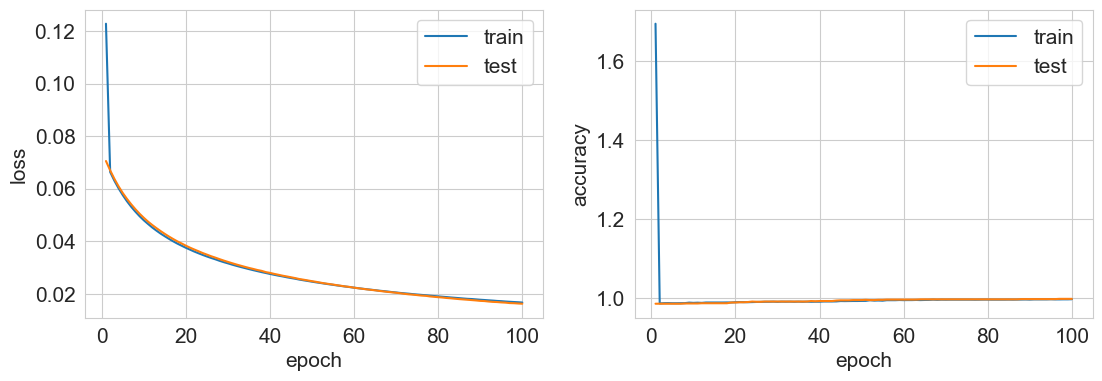

In [55]:
plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

In [56]:
print('train loss', train_loss)
print('test loss', test_loss)
print('train accuracy',  train_accuracy)
print('test accuracy', test_accuracy)

train loss 0.01666591038416761
test loss 0.01621469178630236
train accuracy 0.9966142955155962
test accuracy 0.9975369458128078


### Компьютеры

In [57]:
! kaggle datasets download -d mrsimple07/laptoppriceprediction
! tar -xf laptoppriceprediction.zip


  0%|          | 0.00/39.1k [00:00<?, ?B/s]
100%|██████████| 39.1k/39.1k [00:00<00:00, 353kB/s]
100%|██████████| 39.1k/39.1k [00:00<00:00, 347kB/s]


In [71]:
data = pd.read_csv("Laptop_price.csv")

In [72]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Price'], axis = 1), data['Price'], test_size = 0.2, random_state = 42)

In [73]:
from category_encoders import TargetEncoder
enc = TargetEncoder(return_df = True).fit(X_train['Brand'],  y_train)
X_train['Brand'] = enc.transform(X_train['Brand'])
X_test['Brand'] = enc.transform(X_test['Brand'])

In [82]:
import modules as mm
from tqdm.notebook import tqdm

IN_FEATURES = X_train.shape[1]
NUM_CLASSES = 1
HIDDEN_SIZE = 32

train_loader = mm.DataLoader(X_train.values, y_train.values.squeeze(), batch_size=64, shuffle=True)
test_loader = mm.DataLoader(X_test.values, y_test.values.squeeze(), batch_size=64, shuffle=False)
model = mm.Sequential(
    mm.Linear(in_features = IN_FEATURES, out_features = HIDDEN_SIZE),
    mm.ReLU(),
    mm.Linear(in_features = HIDDEN_SIZE, out_features= HIDDEN_SIZE),
    mm.ReLU(),
    mm.Linear(in_features = HIDDEN_SIZE, out_features = NUM_CLASSES)
)
optimizer = mm.Adam(model, lr=1e-3, weight_decay=0.1)
criterion = mm.MSELoss()

In [83]:
num_epochs = 100
pbar = tqdm(range(1, num_epochs + 1))
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []
for epoch in pbar:
    train_loss, test_loss = 0.0, 0.0

    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        y_batch = np.reshape(y_batch, (predictions.shape[0], predictions.shape[1]))
        loss = criterion(predictions, y_batch)
        model.backward(X_batch, criterion.backward(predictions, y_batch))
        optimizer.step()

        train_loss += loss * X_batch.shape[0]

    model.eval()
    for X_batch, y_batch in test_loader:
        predictions = model(X_batch)
        y_batch = np.reshape(y_batch, (predictions.shape[0], predictions.shape[1]))
        loss = criterion(predictions, y_batch)
        test_loss += loss * X_batch.shape[0]

    train_loss /= train_loader.num_samples()
    test_loss /= test_loader.num_samples()
    train_losses += [train_loss]
    test_losses += [test_loss]
    pbar.set_postfix({'train loss': train_loss, 'test loss': test_loss})

  0%|          | 0/100 [00:00<?, ?it/s]

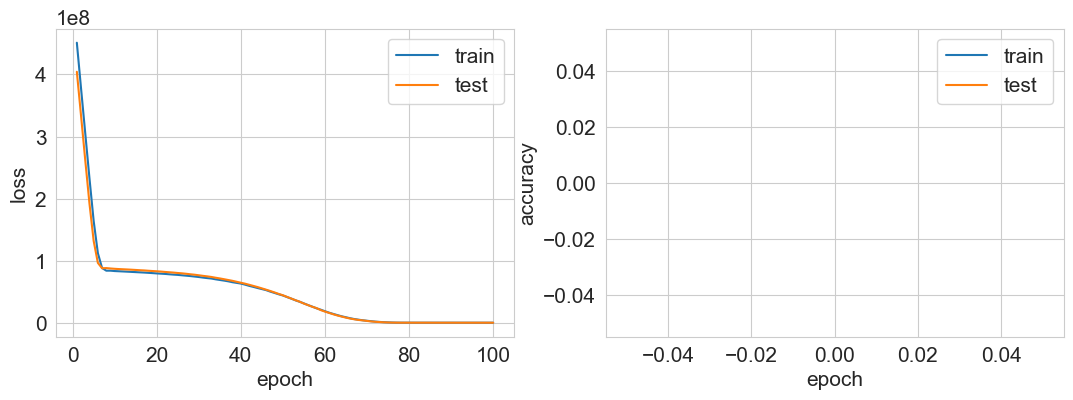

In [84]:
plot_losses(train_losses, test_losses, [], [])


In [85]:
print('train loss', train_loss)
print('test loss', test_loss)

train loss 234619.34553731207
test loss 228170.03682883055
